In [239]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from tensorflow import keras
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import data.preprocess as pre

In [240]:
file = pd.read_json("data.json")
SET_ESS = ["date", "close", "high", "low", "open", "symbol", "volume", "change", "changePercent"]
data = pd.DataFrame(file['GOOG']['chart'])[SET_ESS]
pre.apply_indicators(data)
data.set_index('date',inplace = True)
data = data.filter(['close','ma_cross','macd_cross'])
data.dropna(inplace=True)
data_len = len(data.values)
feature = 3

In [241]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.values)
# predict 360 days
test_size = 360
# 14 days to predict the next day (sliding window)
window = 14 
#split the train data 
train_data = scaled_data[0:data_len-test_size-window,:]
x_train = []
y_train = []
for i in range(window, len(train_data)): 
  x_train.append(train_data[i-window:i, :])
  y_train.append(train_data[i][0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], feature)) 
#split the test_data (for validation)
test_data = scaled_data[data_len-(window+test_size):data_len,:]
x_test = []
y_test = []
for i in range(window, len(test_data)):
  x_test.append(test_data[i-window:i, :])
  y_test.append(test_data[i][0])

x_test,y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], feature))



In [242]:
learning_rate = 0.003
input_model = Input(shape=(window, feature))

# randomly drop 20% training cell
dropout_layer = Dropout(0.2)

# first neurons layers 
Dense_window = Dense(window)

# output layer (1 for the only price output)
Dense_feature = Dense(1)

LSTM_MODEL = LSTM(75,activation='tanh')
output_layer1 = LSTM_MODEL(input_model)
output_layer2 = dropout_layer(output_layer1)
output_layer3 = Dense_window(output_layer2 )
output = Dense_feature(output_layer3)
model = Model(input_model,output)

model.summary()
model.compile(optimizer = keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=50)



Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 14, 3)]           0         
                                                                 
 lstm_30 (LSTM)              (None, 75)                23700     
                                                                 
 dropout_30 (Dropout)        (None, 75)                0         
                                                                 
 dense_60 (Dense)            (None, 14)                1064      
                                                                 
 dense_61 (Dense)            (None, 1)                 15        
                                                                 
Total params: 24,779
Trainable params: 24,779
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
27/27 [==============================] - 4s

In [243]:
predictions = model.predict(x_test)
print('r2_score: ',r2_score(y_test, predictions))
print('MAPE: ',mean_absolute_percentage_error(y_test, predictions))
print('MAE: ', mean_absolute_error(y_test, predictions))
print('MSE: ', mean_squared_error(y_test, predictions,squared=True))
print('rmse: ',mean_squared_error(y_test, predictions,squared=False))

12/12 [==============================] - 0s 2ms/step
r2_score:  0.9551400379413701
MAPE:  0.06920882759230743
MAE:  0.07547482514187152
MSE:  0.009341228650891232
rmse:  0.09665003182043569


C:\Users\lawre\AppData\Local\Temp\ipykernel_30104\1794396903.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict['Predictions'] = predictions


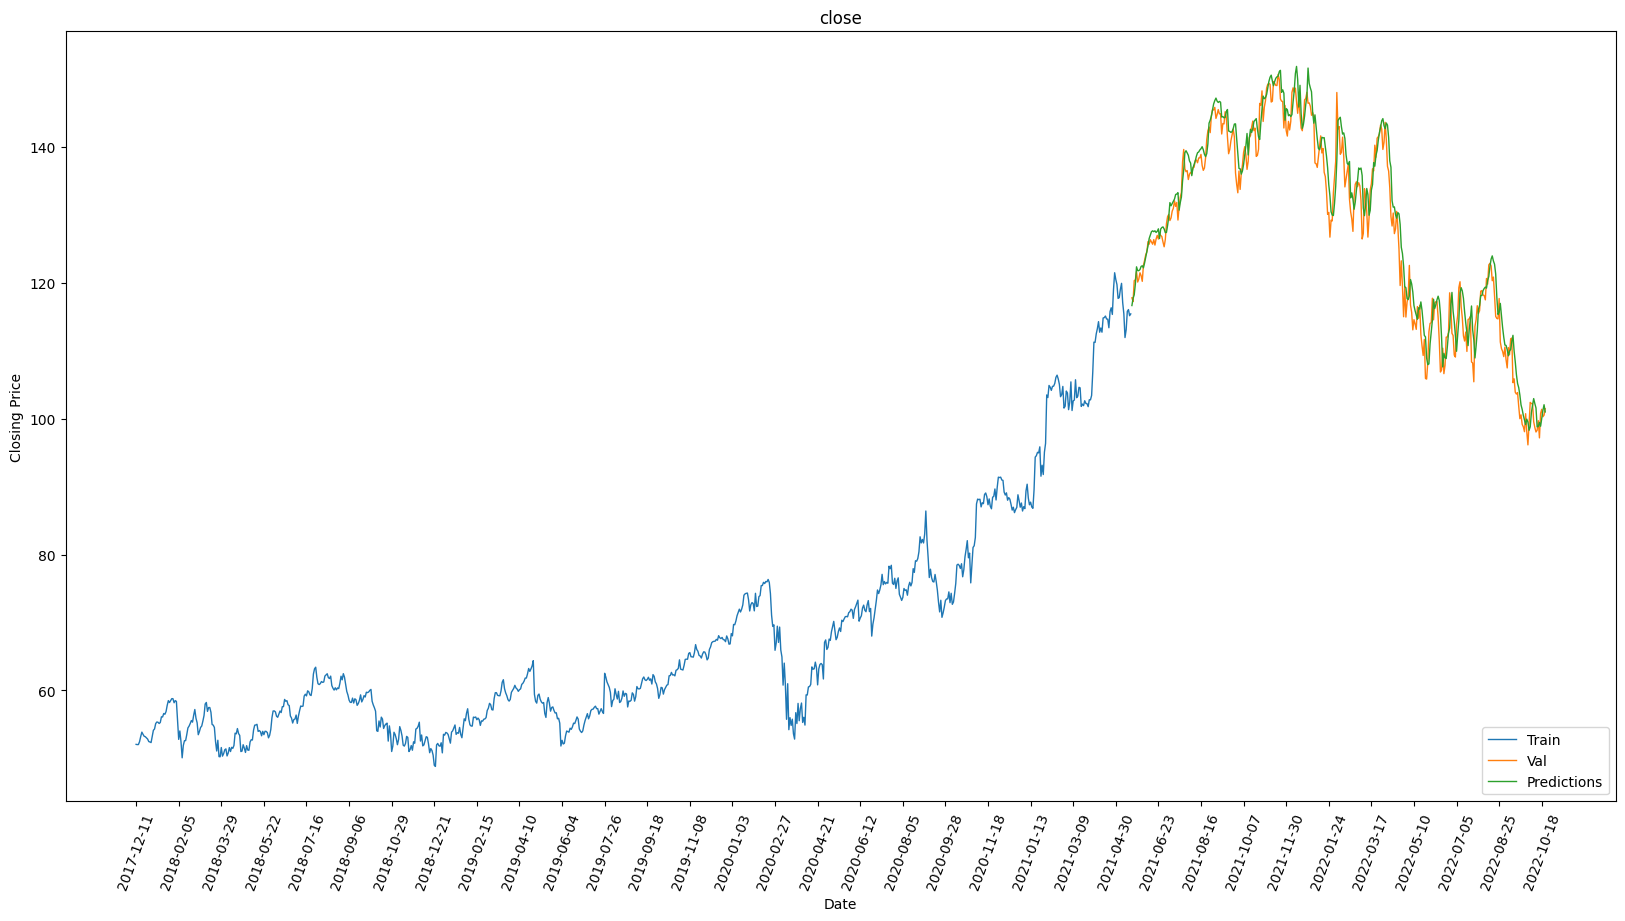

               close  Predictions
date                             
2021-05-20  117.8045   116.665314
2021-05-21  117.2550   117.714593
2021-05-24  120.3335   118.251459
2021-05-25  120.4535   119.834389
2021-05-26  121.6765   122.366755
...              ...          ...
2022-10-17  100.7800    98.896328
2022-10-18  101.3900   100.041518
2022-10-19  100.2900   101.206766
2022-10-20  100.5300   102.062303
2022-10-21  101.4800   101.001523

[360 rows x 2 columns]


In [244]:

Predict_dataset_3D = np.zeros(shape=(len(predictions), 3) )
Predict_dataset_3D[:,0] = predictions[:,0]

predictions = scaler.inverse_transform(Predict_dataset_3D)[:,0]

train = data[:data_len-test_size]
predict = data[data_len-test_size:data_len]
predict['Predictions'] = predictions
plt.figure(figsize=(20,10))
plt.title('close')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(train['close'],linewidth=1)
plt.plot(predict[['close','Predictions']],linewidth=1)
plt.xticks(np.arange(0, len(data.values)+1,37),rotation=70)
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()

print(predict[['close','Predictions']])


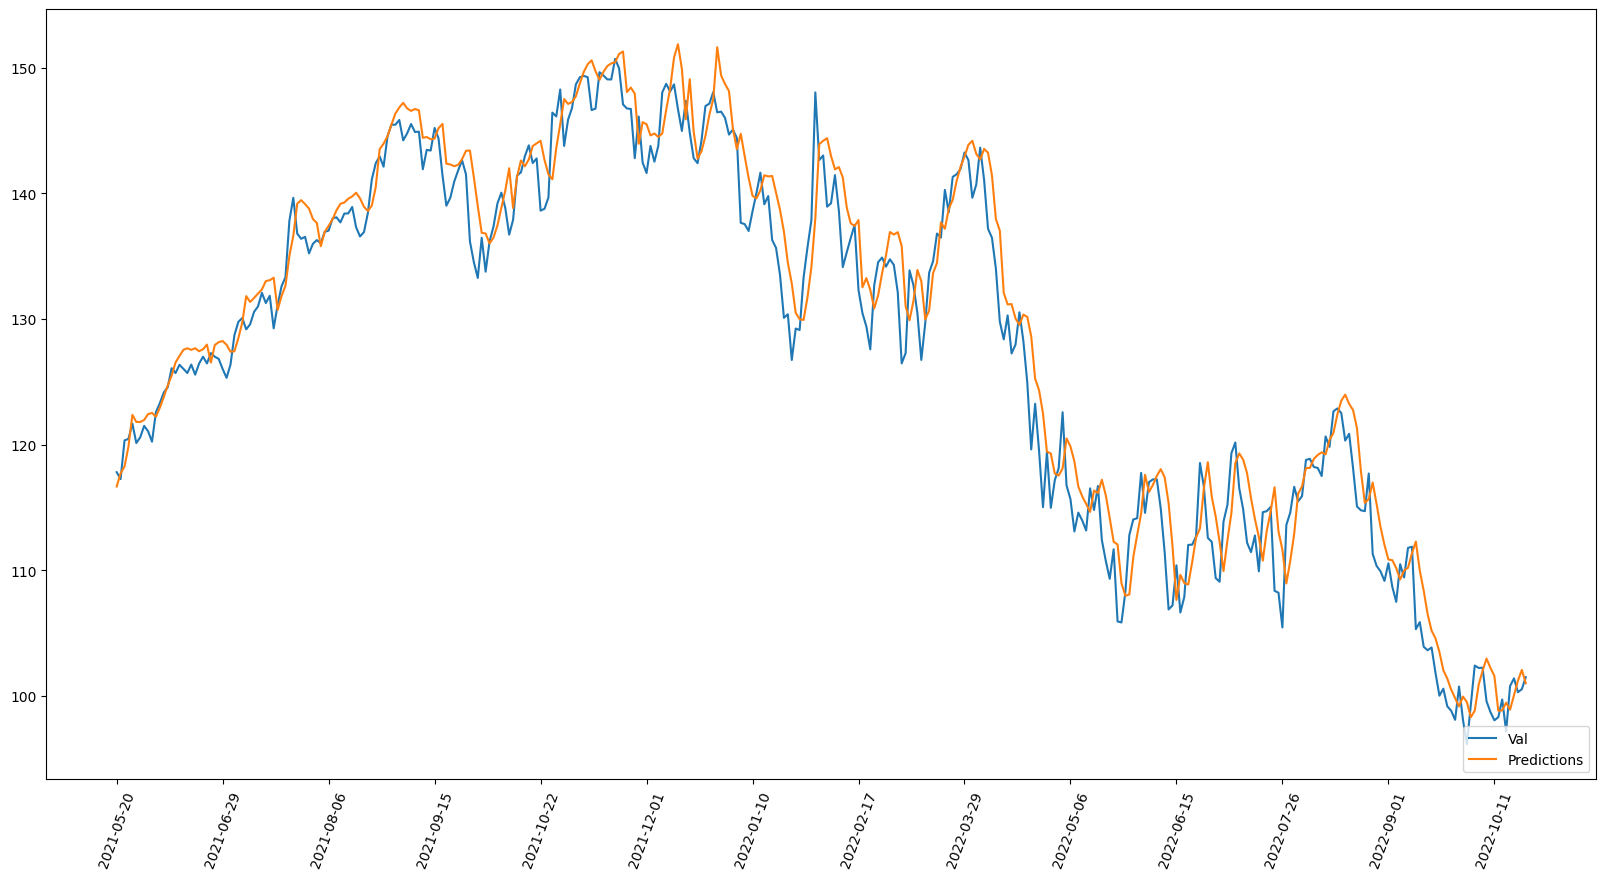

In [245]:
plt.figure(figsize=(20,10))
plt.xticks(np.arange(0, len(predict)+1,27),rotation=70)
plt.plot(predict[['close','Predictions']],linewidth=1.5)
plt.legend(['Val','Predictions'], loc = 'lower right')